v.d.3: Análise exploratória dos dados textuais e pré-processamento do texto (remoção de stopwords, pontuação, etc.).

# Classificação de lançamentos contábeis

1) Descrição do problema: classificar a despesa pública natureza 339036 (outros serviços - pessoa física) com base no histórico da nota de empenho como fato gerador, ou não, das contribuições previdenciárias.

2) Descrição da solução: Construção de features com base no texto do histórico das notas de empenho, treinamento e teste para seleção do modelo de classificação com melhor métrica de desempenho.

3) Fonte de dados: Os dados das notas de empenho estão disponíveis em portais da transparência de diversos órgãos públicos, por exemplo,
https://www.governotransparente.com.br/acessoinfo/44529487/empenhoportipo. No caso, será utilizada uma base de dados rotulados a partir desses dados públicos.

4) Variáveis independentes: texto com o histórico da nota de empenho.

5) Variável dependente. Primeiramente, será classificado apenas como 0 (não é fato gerador) e 1 (é fato gerador). Posteriormente, a classificação incluirá a categoria do segurado: segurado empregado, contribuinte individual, contribuinte individual – condutor autônomo.

## 1. Carregamento dos dados

In [1]:
# Monta google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Carrega os pacotes necessários
import pandas as pd
pd.set_option('display.max_colwidth', None)

In [3]:
# Importa os dados
df_completo = pd.read_excel('/content/drive/My Drive/projeto classificacao de lancamento/dados/despesa liquidada - base completa.xlsx')
df_completo.head()

,Município,Data da Liquidação,Natureza da Despesa,Numero do Empenho,Descrição do Empenho,Fato Gerador,Categoria
0,Concórdia do Pará,2019-01-31,339036,04010020,"Locacao de imovel para funcionamento da casa de apoio da Equipe Tatico metropolitana de Concordia do Para, no periodo de 01 de Janeiro a 31 de Dezembro de 2019.",Não,NaN
1,Concórdia do Pará,2019-01-31,339036,04010019,"Locacao de imovel para funcionamento do arquivo de documentos inativos e deposito de materiais inserviveis do Municipio de Concordia do Para, no periodo de 01 de janeiro a 31 de dezembro de 2019.",Não,NaN
2,Concórdia do Pará,2019-01-30,339036,28010007,"servicos eventuais prestados para atender a Secretaria Municipal de Obras e Transportes, como Mecanico de veiculos da secretaria durante o mes de Janeiro de 2019.",Sim,CI
3,Concórdia do Pará,2019-01-24,339036,18010004,"servicos eventuais prestados como Auxiliar de Servicos Gerais para atender a Secretaria Municipal de Administracao, durante 12 dias do mes de Janeiro de 2019.",Sim,CI
4,Concórdia do Pará,2019-01-24,339036,18010005,"servicos eventuais prestados como Vigia para atender a Secretaria Municipal de Administracao, durante 10 dias do mes de Janeiro de 2019.",Sim,CI


In [4]:
# Seleciona as variáveis de interesse
df = df_completo[['Descrição do Empenho', 'Fato Gerador', 'Categoria']]
df['Categoria'].fillna('Não', inplace=True)
df.columns = ['description', 'target', 'category']
print('Quantidade de registros:', len(df))
df.head()

Quantidade de registros: 37567


<ipython-input-4-56cf9149bc05>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Categoria'].fillna('Não', inplace=True)
<ipython-input-4-56cf9149bc05>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Categoria'].fillna('Não', inplace=True)


,description,target,category
0,"Locacao de imovel para funcionamento da casa de apoio da Equipe Tatico metropolitana de Concordia do Para, no periodo de 01 de Janeiro a 31 de Dezembro de 2019.",Não,Não
1,"Locacao de imovel para funcionamento do arquivo de documentos inativos e deposito de materiais inserviveis do Municipio de Concordia do Para, no periodo de 01 de janeiro a 31 de dezembro de 2019.",Não,Não
2,"servicos eventuais prestados para atender a Secretaria Municipal de Obras e Transportes, como Mecanico de veiculos da secretaria durante o mes de Janeiro de 2019.",Sim,CI
3,"servicos eventuais prestados como Auxiliar de Servicos Gerais para atender a Secretaria Municipal de Administracao, durante 12 dias do mes de Janeiro de 2019.",Sim,CI
4,"servicos eventuais prestados como Vigia para atender a Secretaria Municipal de Administracao, durante 10 dias do mes de Janeiro de 2019.",Sim,CI


## 2. Análise exploratória dos dados (fato gerador)



In [5]:
# Importação das bibliotecas
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')

from collections import Counter
from wordcloud import WordCloud
import string
import re
from operator import imod

import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [8]:
# Lista de palavras positivas
positive_words = df[df["target"] == "Sim"]["description"].to_list()
positive_words = word_tokenize(' '.join(positive_words))

# Lista de palavras negativas
negative_words = df[df["target"] == "Não"]["description"].to_list()
negative_words = word_tokenize(' '.join(negative_words))

### 2.1. Palavras mais frequentes

In [9]:
# Análise de frequência de palavras e nuvem de palavras

# Frequencia das palavras
positive_words_frequency = Counter(positive_words)
negative_words_frequency = Counter(negative_words)

# Seleção das 50 palavras mais comuns
most_common_positive = positive_words_frequency.most_common(50)
most_common_negative = negative_words_frequency.most_common(50)

# DataFrame para facilitar a visualização
df_most_common_positive = pd.DataFrame(most_common_positive, columns=['Palavra', 'Frequência'])
df_most_common_negative = pd.DataFrame(most_common_negative, columns=['Palavra', 'Frequência'])

# Nuvem de palavras dos textos positivos e negativos
wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(' '.join(positive_words))
wordcloud_negative = WordCloud(width=800, height=400, background_color='white').generate(' '.join(negative_words))

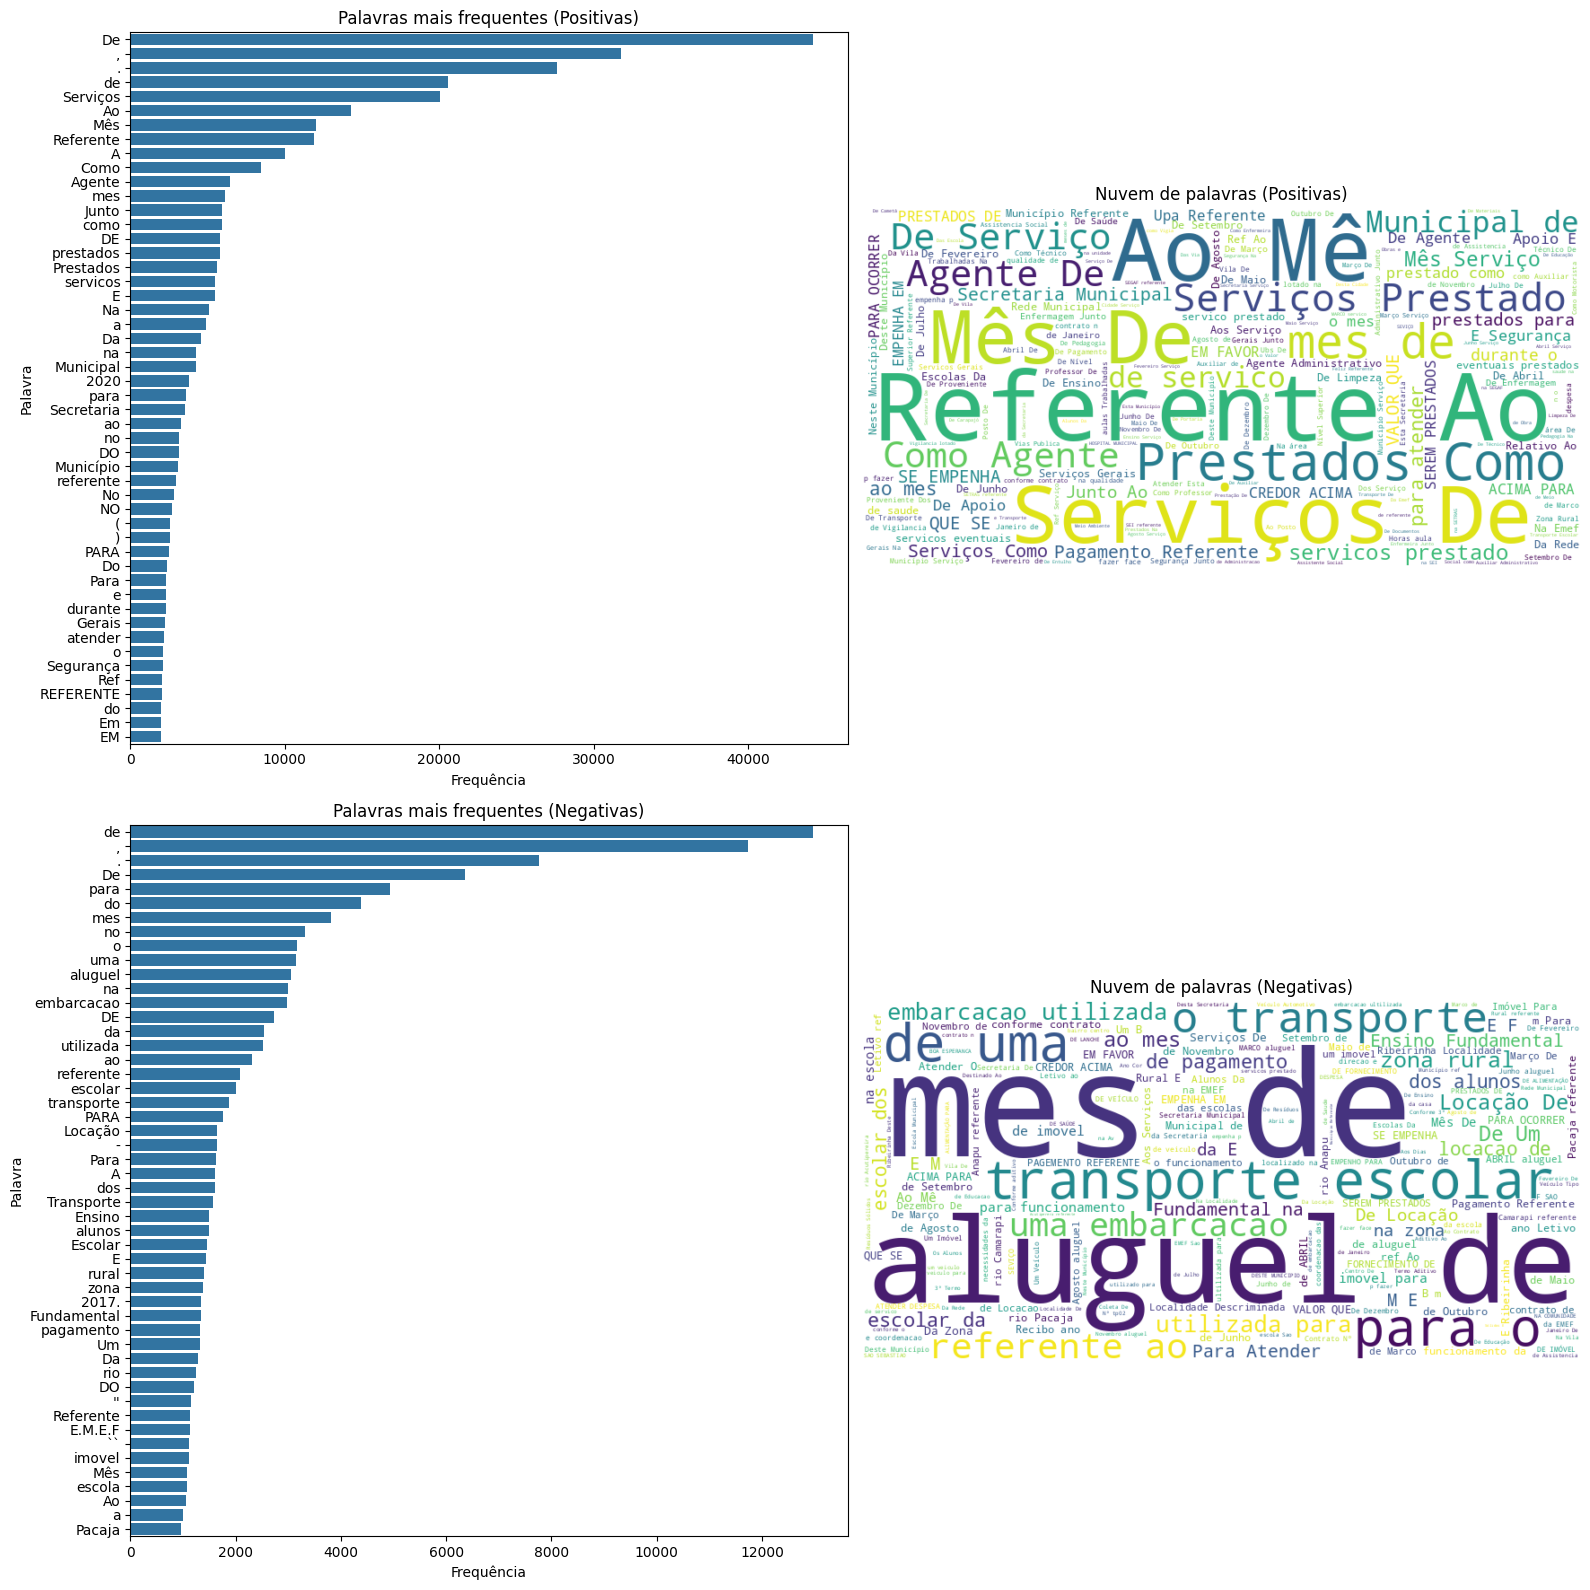

In [10]:
# Plotagem do gráfico de frequencia e da nuvem de palavras
plt.figure(figsize=(16, 16))

# Gráfico das palavras mais frequentes (positivas)
plt.subplot(2, 2, 1)
sns.barplot(x='Frequência', y='Palavra', data=df_most_common_positive)
plt.title('Palavras mais frequentes (Positivas)')

# Nuvem de palavras (positivas)
plt.subplot(2, 2, 2)
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis('off')
plt.title('Nuvem de palavras (Positivas)')

# Gráfico das palavras mais frequentes (negativas)
plt.subplot(2, 2, 3)
sns.barplot(x='Frequência', y='Palavra', data=df_most_common_negative)
plt.title('Palavras mais frequentes (Negativas)')

# Nuvem de palavras (negativas)
plt.subplot(2, 2, 4)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis('off')
plt.title('Nuvem de palavras (Negativas)')

plt.tight_layout()
plt.show()

### 2.2. Limpeza do texto

In [11]:
# Função para limpeza de texto
def limpa_texto(text, stop_words=[]):
    # Remove caracteres especiais
    # \w: corresponde a todos os caracteres alfanuméricos, ou seja, letras e números, mas não acentos ou caracteres especiais. É o equivalente a [a-zA-Z_0-9].
    # \s: corresponde a caracteres de espaço em branco, ou seja, é o equivalente a [\t\n\x0B\f\r].
    # código alternativo: text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'[^\w\s]', '', text)

    # Remove números e minimiza
    text = ''.join(word for word in text if not word.isdigit()).lower()

    # Tokeniza as palavras
    tokens = nltk.word_tokenize(text)

    # Remove as stopwords
    tokens = [word for word in tokens if word not in stop_words]

    return ' '.join(tokens)

In [12]:
# Stopwords da biblioteca nltk em português
stop_words = stopwords.words('portuguese')
print('Quantidade de stop words:', len(stop_words))
print('Primeiras 10 da lista:', stop_words[:10])

Quantidade de stop words: 207
Primeiras 10 da lista: ['a', 'à', 'ao', 'aos', 'aquela', 'aquelas', 'aquele', 'aqueles', 'aquilo', 'as']


In [13]:
# Verificamos que há palavras muito frequentes tanto nos textos positivos como nos negativos.
# Por esse motivo, tais palavras podem ser eliminadas, já que não tem poder discriminatório entre as classes.
most_common_positive_list = [x for x, y in most_common_positive]
most_common_negative_list = [x for x, y in most_common_negative]
most_common = [x for x in most_common_positive_list if x in most_common_negative_list]
print('Palavras mais comuns:\n', most_common)

Palavras mais comuns:
 ['De', ',', '.', 'de', 'Ao', 'Mês', 'Referente', 'A', 'mes', 'DE', 'E', 'a', 'Da', 'na', 'para', 'ao', 'no', 'DO', 'referente', 'PARA', 'Para', 'o', 'do']


In [18]:
stop_words_specific = [x for x in most_common if x not in stop_words]
stop_words_specific = limpa_texto(' '.join(stop_words_specific), stop_words=[]).split()
print('Stopwords específicas:', stop_words_specific)

Stopwords específicas: ['de', 'ao', 'mês', 'referente', 'a', 'mes', 'de', 'e', 'da', 'do', 'referente', 'para', 'para']


In [19]:
stop_words_months = ['janeiro', 'fevereiro', 'março', 'abril', 'maio', 'junho', 'julho', 'agosto', 'setembro', 'outubro', 'novembro', 'dezembro']

In [20]:
stop_words_all = list(set(stop_words + stop_words_specific + stop_words_months))

In [21]:
# Exemplo de uso
text = df['description'][0]
print('Texto:', text)
tokens = limpa_texto(text, stop_words_all)
print('Tokens:', tokens)

Texto: Locacao de imovel para funcionamento da casa de apoio da Equipe Tatico  metropolitana de Concordia do Para, no periodo de 01 de Janeiro a 31 de Dezembro de 2019.
Tokens: locacao imovel funcionamento casa apoio equipe tatico metropolitana concordia periodo


In [22]:
df.head()

,description,target,category
0,"Locacao de imovel para funcionamento da casa de apoio da Equipe Tatico metropolitana de Concordia do Para, no periodo de 01 de Janeiro a 31 de Dezembro de 2019.",Não,Não
1,"Locacao de imovel para funcionamento do arquivo de documentos inativos e deposito de materiais inserviveis do Municipio de Concordia do Para, no periodo de 01 de janeiro a 31 de dezembro de 2019.",Não,Não
2,"servicos eventuais prestados para atender a Secretaria Municipal de Obras e Transportes, como Mecanico de veiculos da secretaria durante o mes de Janeiro de 2019.",Sim,CI
3,"servicos eventuais prestados como Auxiliar de Servicos Gerais para atender a Secretaria Municipal de Administracao, durante 12 dias do mes de Janeiro de 2019.",Sim,CI
4,"servicos eventuais prestados como Vigia para atender a Secretaria Municipal de Administracao, durante 10 dias do mes de Janeiro de 2019.",Sim,CI


In [34]:
df['cleaned_description'] = df['description'].apply(lambda x: limpa_texto(x, stop_words_all))
df.head()

<ipython-input-34-ac98d7332849>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cleaned_description'] = df['description'].apply(lambda x: limpa_texto(x, stop_words_all))


,description,target,category,cleaned_description
0,"Locacao de imovel para funcionamento da casa de apoio da Equipe Tatico metropolitana de Concordia do Para, no periodo de 01 de Janeiro a 31 de Dezembro de 2019.",Não,Não,locacao imovel funcionamento casa apoio equipe tatico metropolitana concordia periodo
1,"Locacao de imovel para funcionamento do arquivo de documentos inativos e deposito de materiais inserviveis do Municipio de Concordia do Para, no periodo de 01 de janeiro a 31 de dezembro de 2019.",Não,Não,locacao imovel funcionamento arquivo documentos inativos deposito materiais inserviveis municipio concordia periodo
2,"servicos eventuais prestados para atender a Secretaria Municipal de Obras e Transportes, como Mecanico de veiculos da secretaria durante o mes de Janeiro de 2019.",Sim,CI,servicos eventuais prestados atender secretaria municipal obras transportes mecanico veiculos secretaria durante
3,"servicos eventuais prestados como Auxiliar de Servicos Gerais para atender a Secretaria Municipal de Administracao, durante 12 dias do mes de Janeiro de 2019.",Sim,CI,servicos eventuais prestados auxiliar servicos gerais atender secretaria municipal administracao durante dias
4,"servicos eventuais prestados como Vigia para atender a Secretaria Municipal de Administracao, durante 10 dias do mes de Janeiro de 2019.",Sim,CI,servicos eventuais prestados vigia atender secretaria municipal administracao durante dias


### 2.3. N-gramas
Definição em português: O termo "n-gram" é usado por linguistas computacionais e engenheiros para se referir a combinações de palavras que ocorrem juntas, normalmente com uma certa frequência. A Wikipedia descreve um n-gram "como uma subsequência de n itens de uma dada sequência. N-grams são usados em diversas áreas de processamento de linguagem natural estatístico e análise de sequências genéticas".
Fonte: https://www.ufrgs.br/luminaidiomas/glossary/term?id=778
> N-gramas fornece uma incipiente noção de contexto às palavras do texto.

In [35]:
# Função para gerar n-gramas
def gera_ngrams(texto, n):
    palavras = texto.split()
    n_grams = zip(*[palavras[i:] for i in range(n)])
    return [' '.join(n_gram) for n_gram in n_grams]

In [36]:
# Exemplo de aplicação
texto = 'servicos prestados carpinteiro lotadoa sei'
palavras = texto.split()
n_grams = zip(*[palavras[i:] for i in range(2)])
print(list(n_grams))

[('servicos', 'prestados'), ('prestados', 'carpinteiro'), ('carpinteiro', 'lotadoa'), ('lotadoa', 'sei')]


In [38]:
# Criar coluna no dataframe com bi-gramas
df['bigramas'] = df['cleaned_description'].apply(lambda x: gera_ngrams(x, 2))
df.head()

<ipython-input-38-ff1e08c62121>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bigramas'] = df['cleaned_description'].apply(lambda x: gera_ngrams(x, 2))


,description,target,category,cleaned_description,bigramas
0,"Locacao de imovel para funcionamento da casa de apoio da Equipe Tatico metropolitana de Concordia do Para, no periodo de 01 de Janeiro a 31 de Dezembro de 2019.",Não,Não,locacao imovel funcionamento casa apoio equipe tatico metropolitana concordia periodo,"[locacao imovel, imovel funcionamento, funcionamento casa, casa apoio, apoio equipe, equipe tatico, tatico metropolitana, metropolitana concordia, concordia periodo]"
1,"Locacao de imovel para funcionamento do arquivo de documentos inativos e deposito de materiais inserviveis do Municipio de Concordia do Para, no periodo de 01 de janeiro a 31 de dezembro de 2019.",Não,Não,locacao imovel funcionamento arquivo documentos inativos deposito materiais inserviveis municipio concordia periodo,"[locacao imovel, imovel funcionamento, funcionamento arquivo, arquivo documentos, documentos inativos, inativos deposito, deposito materiais, materiais inserviveis, inserviveis municipio, municipio concordia, concordia periodo]"
2,"servicos eventuais prestados para atender a Secretaria Municipal de Obras e Transportes, como Mecanico de veiculos da secretaria durante o mes de Janeiro de 2019.",Sim,CI,servicos eventuais prestados atender secretaria municipal obras transportes mecanico veiculos secretaria durante,"[servicos eventuais, eventuais prestados, prestados atender, atender secretaria, secretaria municipal, municipal obras, obras transportes, transportes mecanico, mecanico veiculos, veiculos secretaria, secretaria durante]"
3,"servicos eventuais prestados como Auxiliar de Servicos Gerais para atender a Secretaria Municipal de Administracao, durante 12 dias do mes de Janeiro de 2019.",Sim,CI,servicos eventuais prestados auxiliar servicos gerais atender secretaria municipal administracao durante dias,"[servicos eventuais, eventuais prestados, prestados auxiliar, auxiliar servicos, servicos gerais, gerais atender, atender secretaria, secretaria municipal, municipal administracao, administracao durante, durante dias]"
4,"servicos eventuais prestados como Vigia para atender a Secretaria Municipal de Administracao, durante 10 dias do mes de Janeiro de 2019.",Sim,CI,servicos eventuais prestados vigia atender secretaria municipal administracao durante dias,"[servicos eventuais, eventuais prestados, prestados vigia, vigia atender, atender secretaria, secretaria municipal, municipal administracao, administracao durante, durante dias]"


### 2.4. Lematização
A lematização é uma técnica essencial no campo do Processamento de Linguagem Natural (NLP). Ela busca simplificar a análise textual ao normalizar palavras para sua forma base, conhecida como “lema”. Por exemplo, considere os substantivos “gato”, “gatinho” e “gatos”; todos eles compartilham do lema “gato”.

Fonte: https://medium.com/@guilherme.davedovicz/nlp-para-iniciantes-lematiza%C3%A7%C3%A3o-d3f723fa9ee3

In [39]:
# Função para lematização utilizando spaCy

# Importa bibioteca
import spacy

# Baixa o modelo 'pt_core_news_sm'
spacy.cli.download("pt_core_news_sm")

# Carrega o modelo para português
nlp = spacy.load('pt_core_news_sm')

# Define a função de lematização com spaCy
def lematiza_spacy(texto):
    doc = nlp(texto)
    palavras_lemmatizadas = [token.lemma_ for token in doc]
    return ' '.join(palavras_lemmatizadas)

✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [40]:
# Exemplo de uso
texto_limpo = "servicos prestados carpinteiro lotadoa sei"
texto_lematizado = lematiza_spacy(texto_limpo)
print('Texto original:', texto_limpo)
print('Texto lematizado com spaCy:', texto_lematizado)

Texto original: servicos prestados carpinteiro lotadoa sei
Texto lematizado com spaCy: servico prestar Carpinteiro lotadoa saber


In [43]:
# Cria coluna no dataframe com texto lematizado
df['lemmatized_description'] = df['cleaned_description'].apply(lambda x: lematiza_spacy(x))
df.head()

<ipython-input-43-6a4b2cd1dc12>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['lemmatized_description'] = df['cleaned_description'].apply(lambda x: lematiza_spacy(x))


,description,target,category,cleaned_description,bigramas,lemmatized_description
0,"Locacao de imovel para funcionamento da casa de apoio da Equipe Tatico metropolitana de Concordia do Para, no periodo de 01 de Janeiro a 31 de Dezembro de 2019.",Não,Não,locacao imovel funcionamento casa apoio equipe tatico metropolitana concordia periodo,"[locacao imovel, imovel funcionamento, funcionamento casa, casa apoio, apoio equipe, equipe tatico, tatico metropolitana, metropolitana concordia, concordia periodo]",locacao imovel funcionamento casa apoio equipe tatico metropolitana concorder periodo
1,"Locacao de imovel para funcionamento do arquivo de documentos inativos e deposito de materiais inserviveis do Municipio de Concordia do Para, no periodo de 01 de janeiro a 31 de dezembro de 2019.",Não,Não,locacao imovel funcionamento arquivo documentos inativos deposito materiais inserviveis municipio concordia periodo,"[locacao imovel, imovel funcionamento, funcionamento arquivo, arquivo documentos, documentos inativos, inativos deposito, deposito materiais, materiais inserviveis, inserviveis municipio, municipio concordia, concordia periodo]",locacao imovel funcionamento arquivo documento inativo deposito material inservivel municipio concorder periodo
2,"servicos eventuais prestados para atender a Secretaria Municipal de Obras e Transportes, como Mecanico de veiculos da secretaria durante o mes de Janeiro de 2019.",Sim,CI,servicos eventuais prestados atender secretaria municipal obras transportes mecanico veiculos secretaria durante,"[servicos eventuais, eventuais prestados, prestados atender, atender secretaria, secretaria municipal, municipal obras, obras transportes, transportes mecanico, mecanico veiculos, veiculos secretaria, secretaria durante]",servico eventual prestar atender Secretaria municipal obra transporte mecanico veiculo Secretaria durante
3,"servicos eventuais prestados como Auxiliar de Servicos Gerais para atender a Secretaria Municipal de Administracao, durante 12 dias do mes de Janeiro de 2019.",Sim,CI,servicos eventuais prestados auxiliar servicos gerais atender secretaria municipal administracao durante dias,"[servicos eventuais, eventuais prestados, prestados auxiliar, auxiliar servicos, servicos gerais, gerais atender, atender secretaria, secretaria municipal, municipal administracao, administracao durante, durante dias]",servico eventual prestar auxiliar servico geral atender Secretaria Municipal administracao durante dia
4,"servicos eventuais prestados como Vigia para atender a Secretaria Municipal de Administracao, durante 10 dias do mes de Janeiro de 2019.",Sim,CI,servicos eventuais prestados vigia atender secretaria municipal administracao durante dias,"[servicos eventuais, eventuais prestados, prestados vigia, vigia atender, atender secretaria, secretaria municipal, municipal administracao, administracao durante, durante dias]",servico eventual prestado vigia atender Secretaria Municipal administracao durante dia


## 3. Análise exploratória dos dados (categoria)



In [44]:
# Seleciona as variáveis de interesse
df = df_completo[['Descrição do Empenho', 'Fato Gerador', 'Categoria']]
df['Categoria'].fillna('Não', inplace=True)
df.columns = ['description', 'target', 'category']
print('Quantidade de registros:', len(df))
df.head()

Quantidade de registros: 37567


<ipython-input-44-56cf9149bc05>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Categoria'].fillna('Não', inplace=True)
<ipython-input-44-56cf9149bc05>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Categoria'].fillna('Não', inplace=True)


,description,target,category
0,"Locacao de imovel para funcionamento da casa de apoio da Equipe Tatico metropolitana de Concordia do Para, no periodo de 01 de Janeiro a 31 de Dezembro de 2019.",Não,Não
1,"Locacao de imovel para funcionamento do arquivo de documentos inativos e deposito de materiais inserviveis do Municipio de Concordia do Para, no periodo de 01 de janeiro a 31 de dezembro de 2019.",Não,Não
2,"servicos eventuais prestados para atender a Secretaria Municipal de Obras e Transportes, como Mecanico de veiculos da secretaria durante o mes de Janeiro de 2019.",Sim,CI
3,"servicos eventuais prestados como Auxiliar de Servicos Gerais para atender a Secretaria Municipal de Administracao, durante 12 dias do mes de Janeiro de 2019.",Sim,CI
4,"servicos eventuais prestados como Vigia para atender a Secretaria Municipal de Administracao, durante 10 dias do mes de Janeiro de 2019.",Sim,CI


In [45]:
# Stopwords da biblioteca nltk em português
stop_words = stopwords.words('portuguese')

# Função para limpeza de texto
def limpa_texto(text, stop_words=[]):
    #text = re.sub(r'[^\w\s]', '', text)
    # Remove sinais de pontuação
    text = text.replace('.', ' ')
    text = text.replace(',', ' ')
    text = text.replace(';', ' ')
    text = text.replace(':', ' ')
    text = text.replace('!', ' ')
    text = text.replace('?', ' ')
    text = text.replace('(', ' ')
    text = text.replace(')', ' ')
    text = text.replace('[', ' ')
    text = text.replace(']', ' ')
    text = text.replace('{', ' ')
    text = text.replace('}', ' ')
    text = text.replace('/', ' ')
    text = text.replace('-', ' ')
    text = text.replace('`', ' ')
    text = ''.join(word for word in text if not word.isdigit()).lower()
    tokens = nltk.word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

In [46]:
df['cleaned_description'] = df['description'].apply(lambda x: limpa_texto(x, stop_words))
df.head()

<ipython-input-46-df007c3b9870>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cleaned_description'] = df['description'].apply(lambda x: limpa_texto(x, stop_words))


,description,target,category,cleaned_description
0,"Locacao de imovel para funcionamento da casa de apoio da Equipe Tatico metropolitana de Concordia do Para, no periodo de 01 de Janeiro a 31 de Dezembro de 2019.",Não,Não,locacao imovel funcionamento casa apoio equipe tatico metropolitana concordia periodo janeiro dezembro
1,"Locacao de imovel para funcionamento do arquivo de documentos inativos e deposito de materiais inserviveis do Municipio de Concordia do Para, no periodo de 01 de janeiro a 31 de dezembro de 2019.",Não,Não,locacao imovel funcionamento arquivo documentos inativos deposito materiais inserviveis municipio concordia periodo janeiro dezembro
2,"servicos eventuais prestados para atender a Secretaria Municipal de Obras e Transportes, como Mecanico de veiculos da secretaria durante o mes de Janeiro de 2019.",Sim,CI,servicos eventuais prestados atender secretaria municipal obras transportes mecanico veiculos secretaria durante mes janeiro
3,"servicos eventuais prestados como Auxiliar de Servicos Gerais para atender a Secretaria Municipal de Administracao, durante 12 dias do mes de Janeiro de 2019.",Sim,CI,servicos eventuais prestados auxiliar servicos gerais atender secretaria municipal administracao durante dias mes janeiro
4,"servicos eventuais prestados como Vigia para atender a Secretaria Municipal de Administracao, durante 10 dias do mes de Janeiro de 2019.",Sim,CI,servicos eventuais prestados vigia atender secretaria municipal administracao durante dias mes janeiro


### 3.1. Palavras mais frequentes e nuvem de palavras do curpus

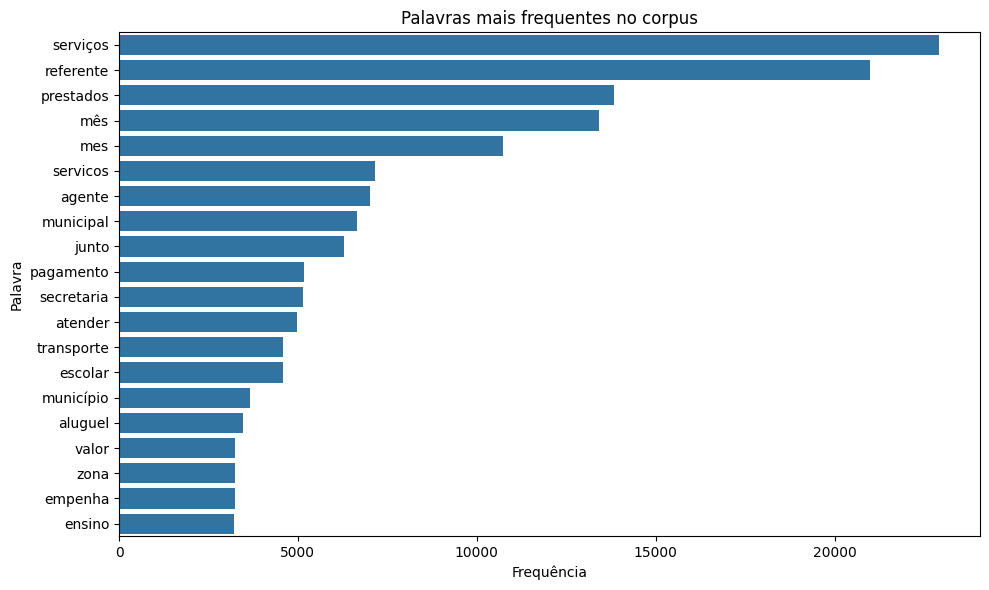

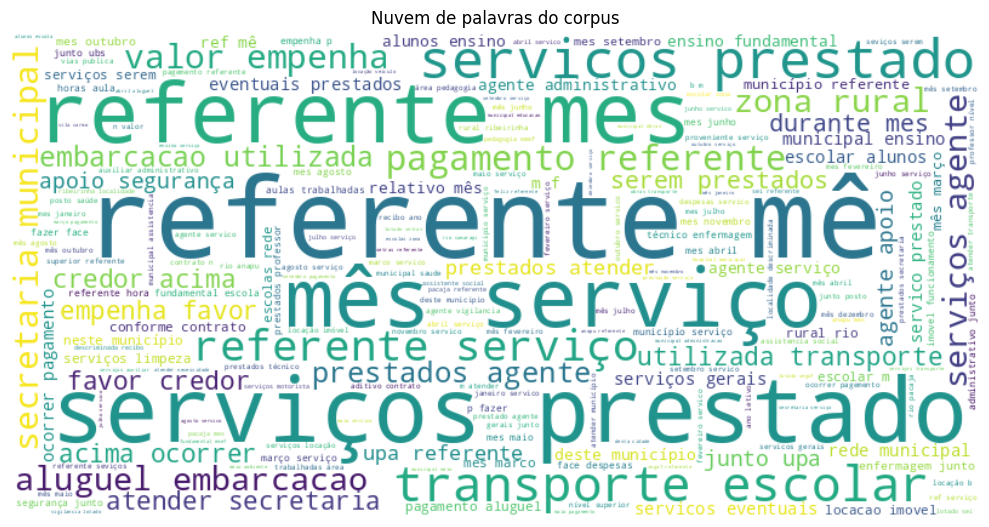

In [47]:
# Nuvem de palavras de todo o corpus
words_corpus = df["cleaned_description"].to_list()
words_corpus = word_tokenize(' '.join(words_corpus))

# Frequencia das palavras
words_frequency_corpus = Counter(words_corpus)

# Seleção das 50 palavras mais comuns
most_common_corpus = words_frequency_corpus.most_common(20)

# DataFrame para facilitar a visualização
df_most_common_corpus = pd.DataFrame(most_common_corpus, columns=['Palavra', 'Frequência'])

# Gráfico das palavras mais frequentes
plt.figure(figsize=(10, 6))
sns.barplot(x='Frequência', y='Palavra', data=df_most_common_corpus)
plt.title('Palavras mais frequentes no corpus')
plt.tight_layout()
plt.show()

# Nuvem de palavras
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df["cleaned_description"]))
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nuvem de palavras do corpus')
plt.tight_layout()
plt.show()

In [48]:
list_most_common_corpus = [x for x, y in most_common_corpus]
print(list_most_common_corpus)

['serviços', 'referente', 'prestados', 'mês', 'mes', 'servicos', 'agente', 'municipal', 'junto', 'pagamento', 'secretaria', 'atender', 'transporte', 'escolar', 'município', 'aluguel', 'valor', 'zona', 'empenha', 'ensino']


### 3.2. Palavras mais frequentes de cada categoria

In [49]:
# Lista de palavras por categoria
ca_words = df[df["category"] == 'CA']["cleaned_description"].to_list()
ca_words = word_tokenize(' '.join(ca_words))

ci_words = df[df["category"] == 'CI']["cleaned_description"].to_list()
ci_words = word_tokenize(' '.join(ci_words))

se_words = df[df["category"] == 'SE']["cleaned_description"].to_list()
se_words = word_tokenize(' '.join(se_words))

nao_words = df[df["category"] == 'Não']["cleaned_description"].to_list()
nao_words = word_tokenize(' '.join(nao_words))

In [50]:
# Análise de frequência de palavras e nuvem de palavras

# Frequencia das palavras
ci_words_frequency = Counter(ci_words)
ca_words_frequency = Counter(ca_words)
se_words_frequency = Counter(se_words)
nao_words_frequency = Counter(nao_words)

# Seleção das 50 palavras mais comuns
most_common_ci = ci_words_frequency.most_common(50)
most_common_ca = ca_words_frequency.most_common(50)
most_common_se = se_words_frequency.most_common(50)
most_common_nao = nao_words_frequency.most_common(50)

# DataFrame para facilitar a visualização
df_most_common_ci = pd.DataFrame(most_common_ci, columns=['Palavra', 'Frequência'])
df_most_common_ca = pd.DataFrame(most_common_ca, columns=['Palavra', 'Frequência'])
df_most_common_se = pd.DataFrame(most_common_se, columns=['Palavra', 'Frequência'])
df_most_common_nao = pd.DataFrame(most_common_nao, columns=['Palavra', 'Frequência'])

# Nuvem de palavras dos textos positivos e negativos
wordcloud_ci = WordCloud(width=800, height=400, background_color='white').generate(' '.join(ci_words))
wordcloud_ca = WordCloud(width=800, height=400, background_color='white').generate(' '.join(ca_words))
wordcloud_se = WordCloud(width=800, height=400, background_color='white').generate(' '.join(se_words))
wordcloud_nao = WordCloud(width=800, height=400, background_color='white').generate(' '.join(nao_words))

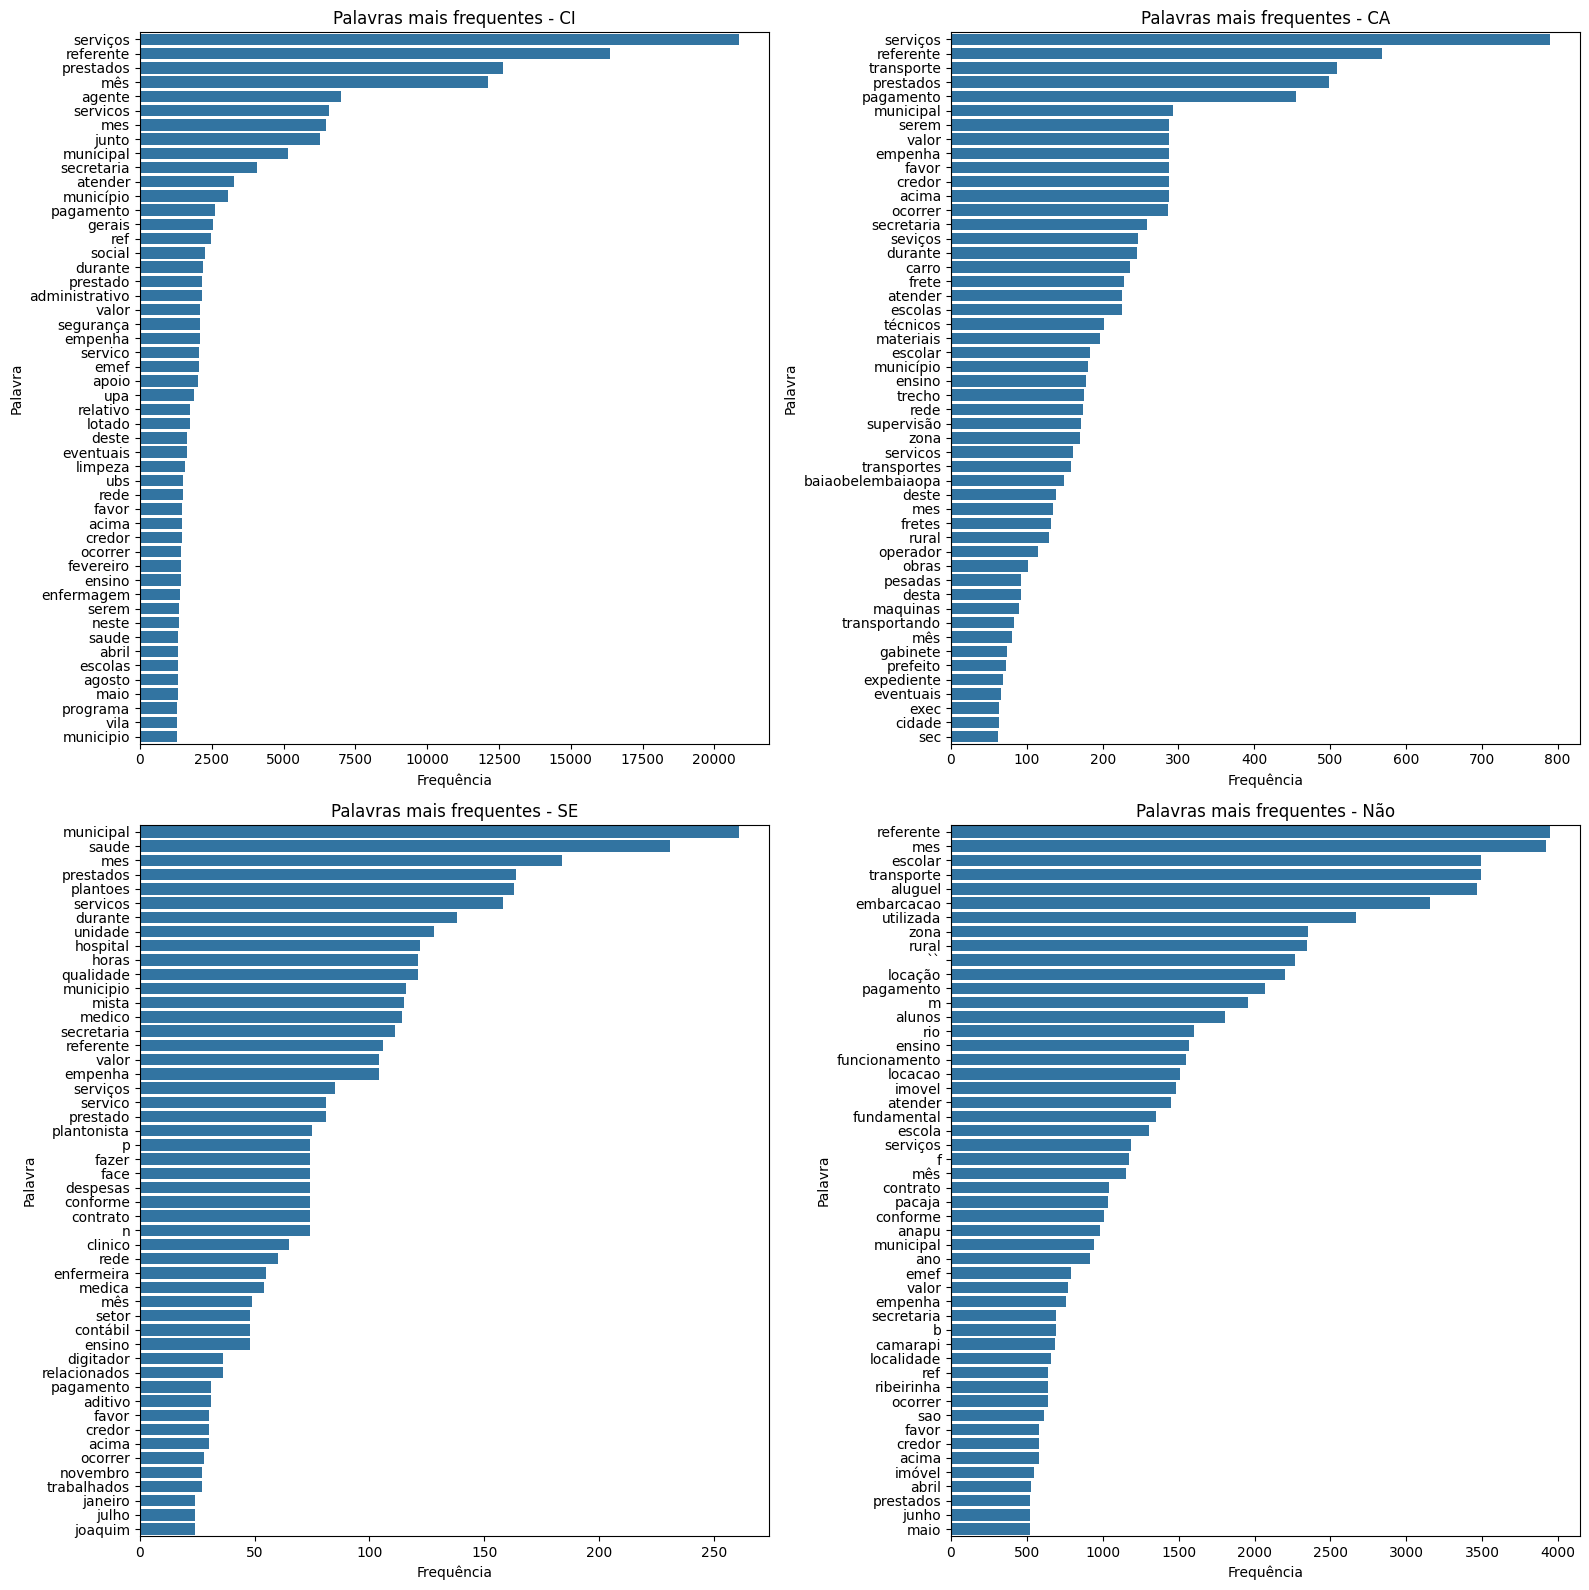

In [51]:
# Plotagem do gráfico de frequencia e da nuvem de palavras
most_common_list = [df_most_common_ci, df_most_common_ca, df_most_common_se, df_most_common_nao]
wordcloud_list = [wordcloud_ci, wordcloud_ca, wordcloud_se, wordcloud_nao]
category_list = ['CI', 'CA', 'SE', 'Não']

# Gráfico das palavras mais frequentes
plt.figure(figsize=(16, 16))
for i in range(len(most_common_list)):
    plt.subplot(2, 2, i+1)
    sns.barplot(x='Frequência', y='Palavra', data=most_common_list[i])
    plt.title('Palavras mais frequentes - ' + category_list[i])
plt.tight_layout()
plt.show()

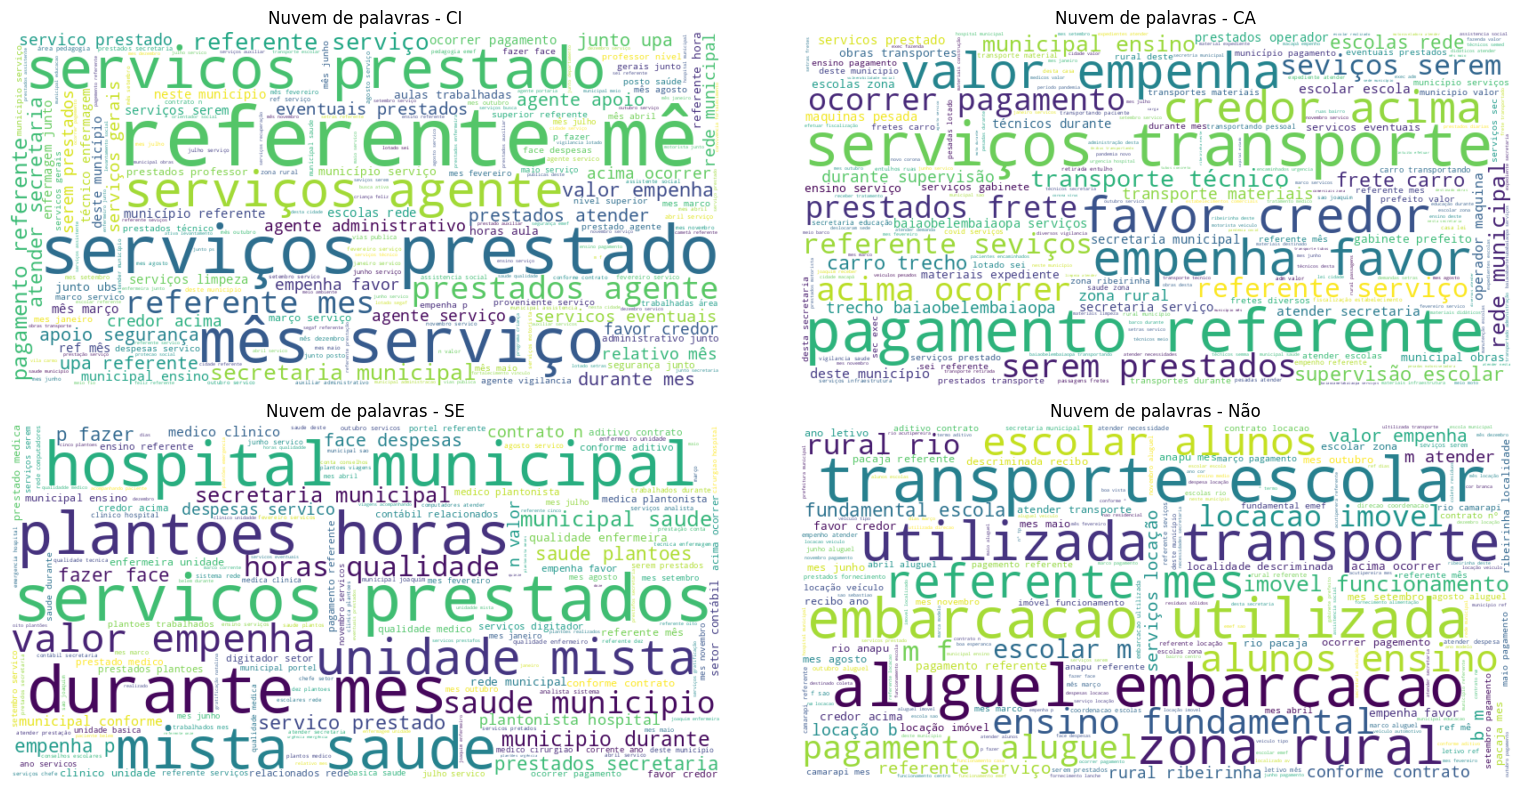

In [52]:
# Nuvem de palavras
plt.figure(figsize=(16, 8))
for i in range(len(most_common_list)):
    plt.subplot(2, 2, i+1)
    plt.imshow(wordcloud_list[i], interpolation='bilinear')
    plt.axis('off')
    plt.title('Nuvem de palavras - ' + category_list[i])
plt.tight_layout()
plt.show()

In [53]:
# Verificamos que há palavras muito frequentes tanto nos textos positivos como nos negativos.
# Por esse motivo, tais palavras podem ser eliminadas, já que não tem poder discriminatório entre as classes.
most_common_ca_list = [x for x, y in most_common_ca]
most_common_ci_list = [x for x, y in most_common_ci]
most_common_se_list = [x for x, y in most_common_se]
most_common_nao_list = [x for x, y in most_common_nao]

most_common = [x for x in most_common_ca_list if (x in most_common_ci_list) and (x in most_common_se_list) and (x in most_common_nao_list)]
print('Palavras mais comuns:\n', most_common)

Palavras mais comuns:
 ['serviços', 'referente', 'prestados', 'pagamento', 'municipal', 'valor', 'empenha', 'favor', 'credor', 'acima', 'ocorrer', 'secretaria', 'ensino', 'mes', 'mês']


In [54]:
stop_words_months = ['janeiro', 'fevereiro', 'março', 'abril', 'maio', 'junho', 'julho', 'agosto', 'setembro', 'outubro', 'novembro', 'dezembro']

In [55]:
stop_words_all = list(set(stop_words + most_common + stop_words_months))

In [56]:
# O treinamento do modelo de árvore de decisão permitiu identificar que nomes de municípios estavam sendo utilizados para ramificação de galhos.
# Como esses nomes não tem valor semântico para classificação, foram removidos.
# A lista final de stopwords utilizada no projeto foi montada da seguinte forma
# Stopwords da biblioteca nltk em português
stop_words_nltk = stopwords.words('portuguese')
# Meses
meses = ['janeiro', 'fevereiro', 'março', 'abril', 'maio', 'junho', 'julho', 'agosto', 'setembro', 'outubro', 'novembro', 'dezembro']
# Stopwords específicas do corpus
corpus_stop_words = ['cameta', 'portel', 'laranjal', 'jari', 'garrafão', 'concordia', 'zona', 'rural', 'belém', 'pacaja', 'pacajar', 'anapu',
                     'aluno', 'mês', 'serviços', 'servicos', 'referente', 'prestados', 'prestados', 'pagamento', 'municipal', 'município', 'valor', 'empenha',
                     'favor', 'credor', 'acima', 'ocorrer', 'secretaria', 'ensino', 'mes', 'mês', 'durante', 'junto', 'atender', 'periodo', 'ref', 'm', '``']
stop_words_final = stop_words_nltk + meses + corpus_stop_words

In [57]:
# Exemplo de uso
text = df['description'][0]
print('Texto:', text)
tokens = limpa_texto(text, stop_words_final)
print('Tokens:', tokens)

Texto: Locacao de imovel para funcionamento da casa de apoio da Equipe Tatico  metropolitana de Concordia do Para, no periodo de 01 de Janeiro a 31 de Dezembro de 2019.
Tokens: locacao imovel funcionamento casa apoio equipe tatico metropolitana


In [58]:
df['cleaned_description'] = df['description'].apply(lambda x: limpa_texto(x, stop_words_final))
df.head()

<ipython-input-58-5c7c08150153>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cleaned_description'] = df['description'].apply(lambda x: limpa_texto(x, stop_words_final))


,description,target,category,cleaned_description
0,"Locacao de imovel para funcionamento da casa de apoio da Equipe Tatico metropolitana de Concordia do Para, no periodo de 01 de Janeiro a 31 de Dezembro de 2019.",Não,Não,locacao imovel funcionamento casa apoio equipe tatico metropolitana
1,"Locacao de imovel para funcionamento do arquivo de documentos inativos e deposito de materiais inserviveis do Municipio de Concordia do Para, no periodo de 01 de janeiro a 31 de dezembro de 2019.",Não,Não,locacao imovel funcionamento arquivo documentos inativos deposito materiais inserviveis municipio
2,"servicos eventuais prestados para atender a Secretaria Municipal de Obras e Transportes, como Mecanico de veiculos da secretaria durante o mes de Janeiro de 2019.",Sim,CI,eventuais obras transportes mecanico veiculos
3,"servicos eventuais prestados como Auxiliar de Servicos Gerais para atender a Secretaria Municipal de Administracao, durante 12 dias do mes de Janeiro de 2019.",Sim,CI,eventuais auxiliar gerais administracao dias
4,"servicos eventuais prestados como Vigia para atender a Secretaria Municipal de Administracao, durante 10 dias do mes de Janeiro de 2019.",Sim,CI,eventuais vigia administracao dias


### 3.3. Palavras mais frequentes de cada categoria após remoção de todas as stopwords

In [59]:
# Lista de palavras por categoria
ca_words = df[df["category"] == 'CA']["cleaned_description"].to_list()
ca_words = word_tokenize(' '.join(ca_words))

ci_words = df[df["category"] == 'CI']["cleaned_description"].to_list()
ci_words = word_tokenize(' '.join(ci_words))

se_words = df[df["category"] == 'SE']["cleaned_description"].to_list()
se_words = word_tokenize(' '.join(se_words))

nao_words = df[df["category"] == 'Não']["cleaned_description"].to_list()
nao_words = word_tokenize(' '.join(nao_words))

In [60]:
# Análise de frequência de palavras e nuvem de palavras

# Frequencia das palavras
ci_words_frequency = Counter(ci_words)
ca_words_frequency = Counter(ca_words)
se_words_frequency = Counter(se_words)
nao_words_frequency = Counter(nao_words)

# Seleção das 50 palavras mais comuns
most_common_ci = ci_words_frequency.most_common(10)
most_common_ca = ca_words_frequency.most_common(10)
most_common_se = se_words_frequency.most_common(10)
most_common_nao = nao_words_frequency.most_common(10)

# DataFrame para facilitar a visualização
df_most_common_ci = pd.DataFrame(most_common_ci, columns=['Palavra', 'Frequência'])
df_most_common_ca = pd.DataFrame(most_common_ca, columns=['Palavra', 'Frequência'])
df_most_common_se = pd.DataFrame(most_common_se, columns=['Palavra', 'Frequência'])
df_most_common_nao = pd.DataFrame(most_common_nao, columns=['Palavra', 'Frequência'])

# Nuvem de palavras dos textos positivos e negativos
wordcloud_ci = WordCloud(width=800, height=400, background_color='white').generate(' '.join(ci_words))
wordcloud_ca = WordCloud(width=800, height=400, background_color='white').generate(' '.join(ca_words))
wordcloud_se = WordCloud(width=800, height=400, background_color='white').generate(' '.join(se_words))
wordcloud_nao = WordCloud(width=800, height=400, background_color='white').generate(' '.join(nao_words))

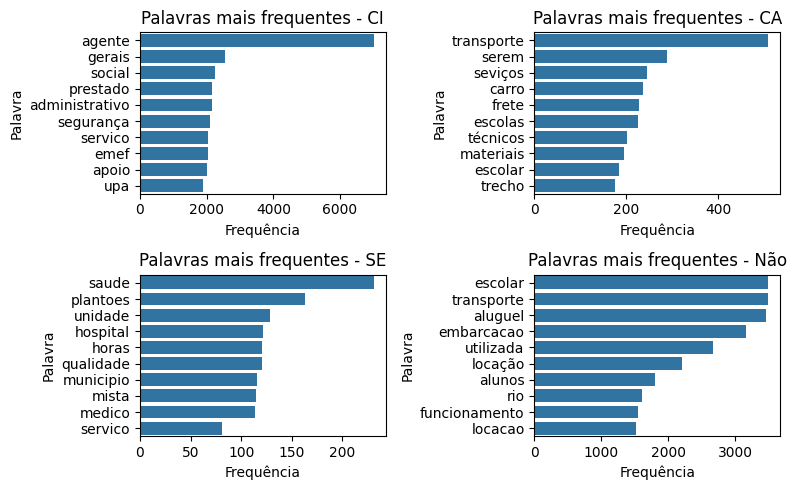

In [61]:
# Plotagem do gráfico de frequencia e da nuvem de palavras
most_common_list = [df_most_common_ci, df_most_common_ca, df_most_common_se, df_most_common_nao]
wordcloud_list = [wordcloud_ci, wordcloud_ca, wordcloud_se, wordcloud_nao]
category_list = ['CI', 'CA', 'SE', 'Não']

# Gráfico das palavras mais frequentes
plt.figure(figsize=(8, 5))
for i in range(len(most_common_list)):
    plt.subplot(2, 2, i+1)
    sns.barplot(x='Frequência', y='Palavra', data=most_common_list[i])
    plt.title('Palavras mais frequentes - ' + category_list[i])
plt.tight_layout()
plt.show()